In [7]:
import anndata as ad
import numpy as np
import pandas as pd
import os.path as osp

from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt

## SLIDE-SEQ

In [4]:
DIR ="/home/alma/w-projects/ccf/data/slideseq-hippo/Puck_200115_08/raw"
CNT_PTH = osp.join(DIR,"Puck_200115_08.digital_expression.txt")
MTA_PTH = osp.join(DIR,"Puck_200115_08_bead_locations.csv")


In [24]:
cnt =pd.read_csv(CNT_PTH,sep ="\t",index_col = 0, header = 0)


In [40]:
index = cnt.index
columns = cnt.columns

In [41]:
cnt = csr_matrix(cnt.values)

In [42]:
cnt = cnt.T

In [45]:
np.save("/tmp/cnt.npy",cnt)

In [ ]:
mta = pd.read_csv(MTA_PTH,header = 0,sep=",",index_col = 0)

In [63]:
adata = ad.AnnData(cnt,
                   var = pd.DataFrame(index.values,index = index,columns = ["Gene"]),
                   obs = mta,
                  )

In [65]:
adata.obsm["spatial"] = adata.obs[["xcoord","ycoord"]].values

In [66]:
adata.write_h5ad(osp.join(osp.dirname(DIR),osp.join("curated","Puck_200115_08.h5ad")))

In [ ]:
%restart

In [105]:
adata = ad.read_h5ad(osp.join(osp.dirname(DIR),osp.join("curated","Puck_200115_08.h5ad")))

In [106]:
adata

AnnData object with n_obs × n_vars = 53208 × 23264
    obs: 'xcoord', 'ycoord'
    var: 'Gene'
    uns: 'curated_landmarks', 'spatial'
    obsm: 'spatial'

In [107]:
tot_cnt = np.array(np.sum(adata.X,axis=1)).flatten()

In [108]:
crd = adata.obsm["spatial"]
crd = crd - crd[:,0].min(axis=0)
crd = crd / crd.max() * 1999

In [18]:
%matplotlib inline
np.sum(tot_cnt < 100) / len(tot_cnt)

0.2144414373778379

<IPython.core.display.Javascript object>


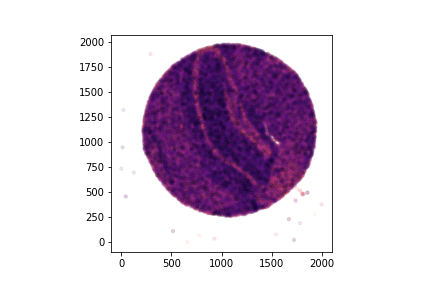

[]

In [20]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(crd[:,1],
           crd[:,0],
            s = 10,
            c = np.log10(tot_cnt),
            alpha = 0.1,
            cmap = plt.cm.magma)

ax.set_aspect("equal")
plt.plot()

In [109]:
LMK_PTH ="/home/alma/w-projects/ccf/data/slideseq-hippo/Puck_200115_08/curated/lmks.txt"

with open(LMK_PTH,"r+") as f:
    lmk_crd = f.readlines()

lmk_crd = np.array([x.rstrip("\n").split(",") for x in lmk_crd]).astype(np.float32)

In [110]:
lmk_crd

array([[1345.,  547.],
       [ 928.,  888.],
       [ 875., 1916.],
       [1474.,  870.],
       [1028., 1570.]], dtype=float32)

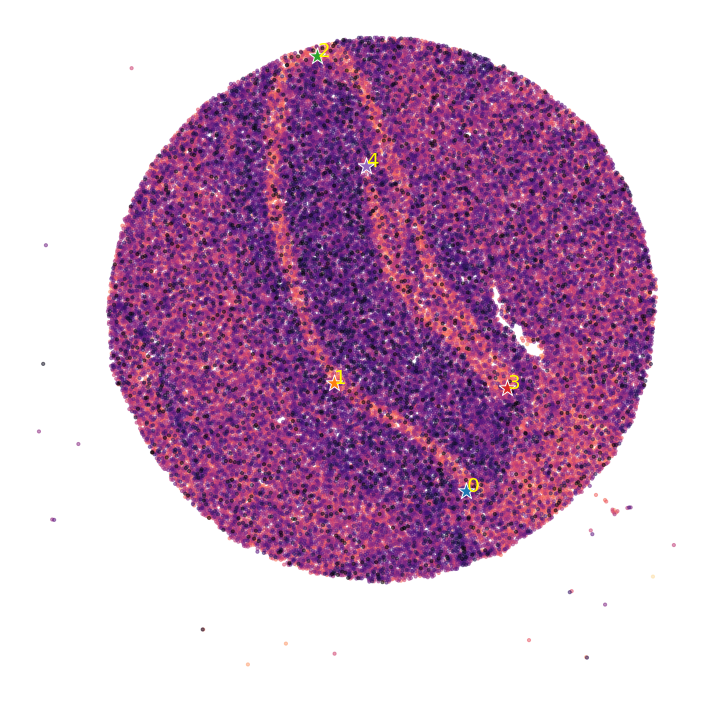

In [111]:
%matplotlib inline
fig,ax = plt.subplots(1,1,figsize = (10,10),facecolor = "white")
ax.scatter(crd[:,1],
           crd[:,0],
            s = 10,
            c = np.log10(tot_cnt),
            alpha = 0.5,
            cmap = plt.cm.magma)

for ii in range(len(lmk_crd)):
    ax.scatter(lmk_crd[ii,0],
               lmk_crd[ii,1],
               s = 300,
               marker = "*",
               edgecolor ="white",
              )
    
    ax.text(lmk_crd[ii,0],lmk_crd[ii,1],str(ii),fontsize = 20,color = "yellow")
ax.axis("off")
ax.set_aspect("equal")
plt.plot()
fig.tight_layout()
fig.savefig(osp.join(osp.dirname(LMK_PTH),"landmark-visual.png"))

In [112]:
lmk = pd.DataFrame(lmk_crd,
                   index = ["Landmark_{}".format(x) for x in range(len(lmk_crd))],
                   columns = ["x_coord","y_coord"],
                  )

In [113]:
adata.uns["curated_landmarks"] = lmk_crd

In [114]:
adata.uns["spatial"] = dict(Puck_200115_08 = dict(scalefactors=dict(tissue_hires_scalef=1)))

In [119]:
adata.obsm["spatial"] = crd[:,[1,0]]

In [120]:
adata.write_h5ad(osp.join(osp.dirname(DIR),osp.join("curated","Puck_200115_08.h5ad")))

In [116]:
print(osp.join(osp.dirname(DIR),osp.join("curated","Puck_200115_08.h5ad")))

/home/alma/w-projects/ccf/data/slideseq-hippo/Puck_200115_08/curated/Puck_200115_08.h5ad


## Visium

In [2]:
import scanpy as sc
VIS_PTH ="/home/alma/w-projects/ccf/data/visium-hippo"


In [23]:
adata = sc.read_visium(VIS_PTH)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [25]:
adata.obs["total"] = adata.X.sum(axis=1)

In [5]:
%matplotlib notebook
crd = adata.obsm["spatial"]
plt.scatter(crd[:,0],crd[:,1],c = adata.obs["total"],s = 5)
plt.axis("equal")

NameError: name 'plt' is not defined

(1637.75, 8903.25, 814.0, 10428.0)

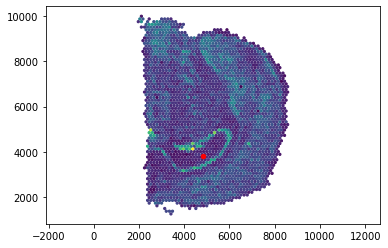

In [70]:
%matplotlib inline
x = 4810
y = 3830
plt.scatter(crd[:,0],crd[:,1],c = adata.obs["total"],s = 5)
plt.scatter(x,y,s = 20,c = "red")
plt.axis("equal")

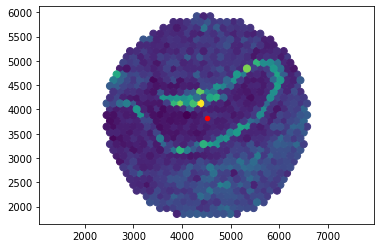

In [28]:
%matplotlib inline

x = 4510
y = 3830
r = 2100

keep = []
for ii in range(len(crd)):
    r2 = (crd[ii,0]-x)**2 + (crd[ii,1]-y)**2
    if r2 <= r**2:
        keep.append(ii)
keep = np.array(keep)

plt.scatter(crd[keep,0],crd[keep,1],c = adata.obs["total"][keep],s = 50)
plt.scatter(x,y,s = 20,c = "red")
plt.axis("equal")
plt.show()

In [29]:
adata = adata[keep,:]

Trying to set attribute `.var` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'feature_types' as categorical
Trying to set attribute `.var` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'genome' as categorical


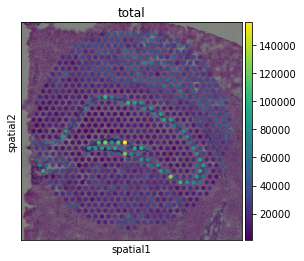

In [30]:
sc.pl.spatial(adata,color =["total"])

In [96]:
VIS_PTH

'/home/alma/w-projects/ccf/data/visium-hippo'

In [31]:
adata.write_h5ad(osp.join(VIS_PTH,"hippo-only.h5ad"))